# Imports

In [4]:
import os
import copy
from PIL import Image
from typing import List

from osgeo import gdal
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
import scipy.ndimage
gdal.UseExceptions()

from apps.colors import Blue2RedColorMaps, Coloring
from apps.parts import process
from apps.mapper import (
    SlopeOptions, TriOptions, TpiOptions, HillshadeOptions
)
from apps.kernels import Kernels

b2r_cmaps = Blue2RedColorMaps()
coloring = Coloring()

# Argments

In [2]:
dirname = r'./datasets/'
INPUT_FILE = os.path.join(dirname, 'DTM_Kouchi__R5M.tif')
SELECTED_MAP = 'CS立体図風'
OUTPUT_FILE = os.path.join(dirname, 'CS_Map__R0_5M.tif')

org_dst = gdal.Open(INPUT_FILE)


# Extend options
# Slope Options
slope_options = SlopeOptions(
    checked=True,
    resampling=False,
    resolution=10,
    cmap=cs_cmaps.slope().colors_255,
)

# Topographic Position Index Options
tpi_options = TpiOptions(
    checked=True,
    one_side_distance=20.0,
    kernel_type='Doughnut',
    outlier_treatment=True,
    sigma=.0,
    threshold=1.5,
    cmap=cs_cmaps.tpi().colors_255,
)

# Terrain Ruggedness Index Options
tri_options = TriOptions(
    checked=True,
    outlier_treatment=True,
    threshold=1.5,
    cmap=cs_cmaps.tri().colors_255,
)

# Hillshade Options
hillshade_options = HillshadeOptions(
    checked=True,
    hillshade_type=1,
    azimuth=315,
    altitude=45,
    z_factor=1.5,
    combined=True,
    cmap=cs_cmaps.hillshade().colors_255,
)


In [3]:
slope_ary = slope_options.to_slope(org_dst)
slope_img = coloring.styling(slope_ary, slope_options.cmap)
slope_img = Image.fromarray(slope_img)

d:\Repositories\ProcessingRaster\apps\colors.py:205: RuntimeWarning: invalid value encountered in cast
  return scaled.astype('uint8')


In [4]:
tpi_ary = tpi_options.to_tpi(org_dst)
tpi_img = coloring.styling(tpi_ary, tpi_options.cmap)
tpi_img = Image.fromarray(tpi_img)

In [5]:
tri = tri_options.to_tri(org_dst)
tri_img = coloring.styling(tri, tri_options.cmap)
tri_img = Image.fromarray(tri_img)

In [6]:
hillshade_ary = hillshade_options.to_hillshade(org_dst)
hillshade_img = coloring.styling(hillshade_ary, hillshade_options.cmap)
hillshade_img = Image.fromarray(hillshade_img)

In [7]:
composite_img = Image.alpha_composite(hillshade_img, tri_img)
composite_img = Image.alpha_composite(composite_img, tpi_img)
composite_img = Image.alpha_composite(composite_img, slope_img)

In [9]:
result = np.array(composite_img)
ary2d_lst = []
for i in range(result.shape[2]):
    ary2d_lst.append(result[:, :, i])




NEW_FILE = os.path.join(dirname, 'CS_MAP_5M_K20.tif')

driver = gdal.GetDriverByName('GTiff')
driver.Register()
new_dst = driver.Create(
    NEW_FILE,
    xsize=org_dst.RasterXSize, 
    ysize=org_dst.RasterYSize, 
    bands=4, 
    eType=gdal.GDT_Byte
)

new_dst.SetGeoTransform(org_dst.GetGeoTransform())
new_dst.SetProjection(org_dst.GetProjection())
set_colors = [
    gdal.GCI_RedBand,
    gdal.GCI_GreenBand,
    gdal.GCI_BlueBand,
    gdal.GCI_AlphaBand
]
for i, (write_img, set_color) in enumerate(zip(ary2d_lst, set_colors), start=1):
    band = new_dst.GetRasterBand(i)
    band.WriteArray(write_img)
    band.SetColorInterpretation(set_color)

new_dst.FlushCache()
new_dst = None

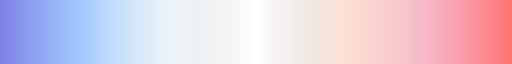

In [10]:
from matplotlib.colors import LinearSegmentedColormap

LinearSegmentedColormap.from_list(
    name='tpi',
    colors=[[0.0, 0.0, 0.8039, 0.5],
            [0.0, 0.4392, 1.0, 0.35],
            [0.5059, 0.7216, 0.8706, 0.15],
            [0.0, 0.0, 0.0, 0.0],
            [0.9294, 0.4275, 0.2078, 0.20],
            [0.9059, 0.2078, 0.3843, 0.35],
            [0.902, 0.0, 0.0, 0.55]],
    N=256
)

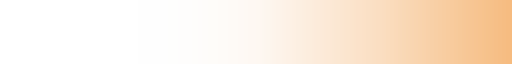

In [17]:
LinearSegmentedColormap.from_list(
    name='tpi',
    colors=[[1.0, 1.0, 1.0, 0.0],
            [1.0, 1.0, 1.0, 0.0],
            [0.9333, 0.4706, 0.0, 0.05],
            [0.9333, 0.4706, 0.0, 0.25],
            [0.9333, 0.4706, 0.0, 0.5]],
    N=256
)

In [16]:
from matplotlib.colors import to_rgba

[round(v , 4) for v in to_rgba('#ee7800')]

[0.9333, 0.4706, 0.0, 1.0]